# **Person classification in artworks Challenge - IMA205 Report**

**CHEN Eric**

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread # Install scikit-image if needed
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import hog
 
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50

from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, Dropout, Flatten, Convolution2D, Activation
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
 
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

Using TensorFlow backend.


In the data folder you can find 2 [CSV](https://fr.wikipedia.org/wiki/Comma-separated_values) files and a folder name im cointining 10000 images of artworks images (mostly paintings). The first CSV file is train.csv, it contains the name of the image with the class of each image. You can read it with [pandas](https://pandas.pydata.org/) as follow :

In [0]:
df = pd.read_csv('data/train.csv')
X_df = df['name']
y_df = df['person']
X = X_df.values
y = y_df.values

In [5]:
labels_counts_df = df.groupby('person').count()
labels_counts_df = labels_counts_df.rename(columns={'person': 'count'})
labels_counts_df

,name
person,
0,3551
1,1449


We notice that in this training dataset, there is not an equal number of images from the same class. In order to train efficiently every class of our data, we can add a class weight on each class. 
In our case, there is a ratio of 2.4:1 between class 0 and class 1.  

In [0]:
class_weight = {0: 1,                
                1: 2.4} 

Let's print some images in order to vizualise our data.

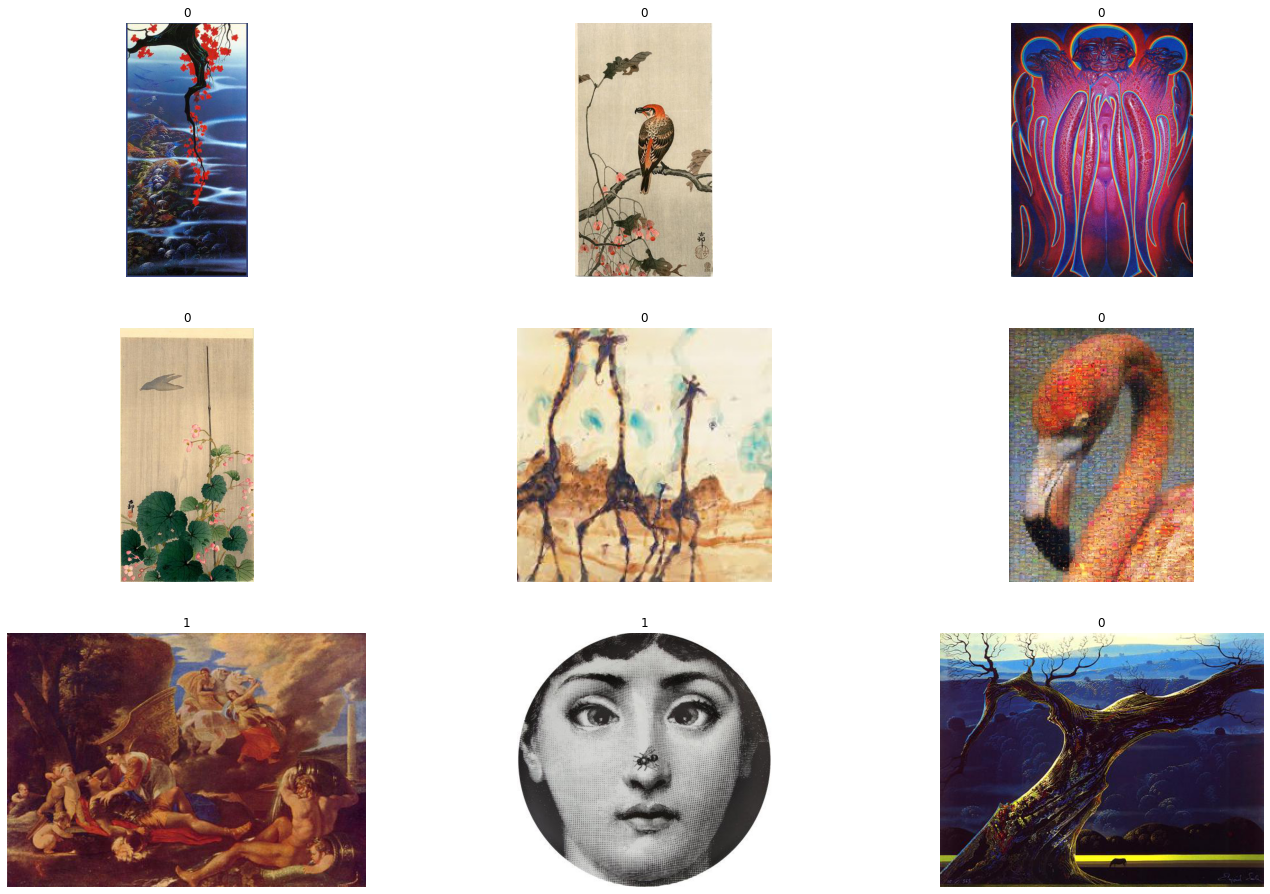

In [0]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3):
    for j in range(0,3):
        index = random.randint(0,X.shape[0])
        image = imread('data/im/{}.jpg'.format(X[index]))
        ax[i,j].imshow(image)
        ax[i,j].set_title(y[index])
        ax[i,j].axis('off')

We can see that each of the images from the training set is labeled, which is 
a characteristic of supervised learning. Our aim will be to classify the images by labeling them. The class 1 corresponds to the case where there is at least one person in the image whereas the class 0 is the opposite.

Our approach will be to extract images features from the training dataset and to classify them.

## I) HOG and SVM

In this analysis, Support Vector Machines (SVM) are used to train a model to classify if an image contains a person or not. The feature representation method Histogram of Oriented Gradients (HOG) are used as the feature representation. Although deep learning approaches have proven there superiority in similar image recognition/classification problem, given the small size of the data set it is interesting to find out how a traditional computer vision approach performs in a situation like this.

In [0]:
train_image = []
image_size = (224,224)
for i in range(X.shape[0]):
    image = imread('data/im/{}.jpg'.format(X[i]))
    image = resize(image, image_size, mode='reflect')
    #image = image/255
    train_image.append(image)
train_image = np.array(train_image)

In [0]:
# We apply the HOG method to all the images of the training dataset and we split them into train and test set
features_hog = []
image_hog = []
for resized_img in train_image:
    fd, hog_image = hog(resized_img, orientations=8, pixels_per_cell=(8,8),cells_per_block=(4, 4),block_norm= 'L2',visualize=True, multichannel=True)
    features_hog.append(fd)
    image_hog.append(hog_image)
features_hog = np.array(features_hog)
image_hog = np.array(image_hog)

X_train, X_test, y_train, y_test = train_test_split(features_hog, y, test_size=0.2, random_state=42)

We can visualize the features extracted by the HOG method.
We can see that it is difficult to recognize the different parts of the image. Indeed, in some images, there are a lot of objects that are not related to a person. The problem is that these objects are taken into account in the feature extraction which can problematic for the classification. 

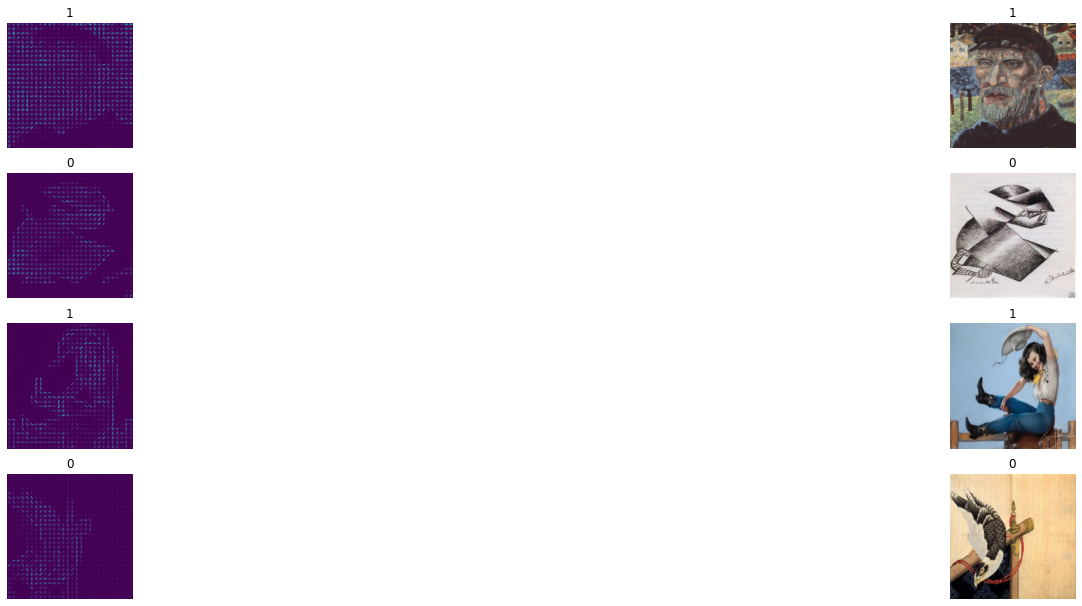

In [0]:
f,ax = plt.subplots(4,2) 
f.subplots_adjust(0,0,4,2)
for i in range(0,4):
    index = random.randint(0,X.shape[0])
    j = 0
    image = image_hog[index]
    ax[i,j].imshow(image)
    ax[i,j].set_title(y[index])
    ax[i,j].axis('off')
    j = 1
    image = train_image[index]
    ax[i,j].imshow(image)
    ax[i,j].set_title(y[index])
    ax[i,j].axis('off')

Then, a linear SVM is used to train and classify the data. It can give us a first view of how well or how bad the extracted features are suited for classification.

In [0]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       654
           1       0.41      0.29      0.34       346

    accuracy                           0.61      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.59      0.61      0.59      1000



What is interesting to observe through the provided metrics is that the images of class 1 are mainly misclassified because we have a very low value. Indeed, the problem we have mentioned above can explain the fact that the model cannot efficiently recognize if a person is present or not in an image. As a result, the model mainly classifies all the images as being part of class 0.

Thus, the combination of HOG and SVM is not enough in order to classify the data. Let's change our approach by using deep learning to classify the images.

## II) Convolutional Neural Network

A convolutional neural network (CNN) can be used to progressively extract higher- and higher-level representations of the image content. Instead of preprocessing the data to derive features like textures and shapes, a CNN takes the image’s raw pixel data as input and “learns” how to extract these features, and ultimately infer what object they constitute.

We first resize the data in order to have images of the same shape, so that they can be all be inputs of the CNN we are going to build.

In [0]:
train_image = []
image_size = (224,224)
ROWS = image_size[0]
COLS = image_size[1]
for i in range(X.shape[0]):
    image = imread('data/im/{}.jpg'.format(X[i]))
    image = resize(image, image_size)
    image = image/255
    train_image.append(image)
train_image = np.array(train_image)

X_train, X_test, y_train, y_test = train_test_split(train_image, y, test_size=0.2, random_state=42)

We build the CNN as follows : it consists in the use of successive convolutions and we apply a relu function. Then, we use MaxPooling. Convolution operation (using an appropriate filter) detects certain features in images, such as horizontal or vertical edges. The pooling layer looks at larger regions (having multiple patches) of the image and captures an aggregate statistic (max, average, etc.) of each region to make the network invariant to local transformations. The output of the last pooling layer is flattened out to a large vector. It contains a sigmoid activation function, which outputs a probability value from 0 to 1 for each of the classification labels the model is trying to predict.

In [0]:
# load the model
optimizer = Adam(lr=0.001)
objective = 'binary_crossentropy'

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(ROWS, COLS, 3), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [0]:
nb_epoch = 5
batch_size = 64
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, class_weight = class_weight,
              verbose=1, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 11s 4ms/step - loss: 0.9965 - accuracy: 0.3675 - val_loss: 0.8298 - val_accuracy: 0.1225
Epoch 2/5
3200/3200 [==============================] - 11s 3ms/step - loss: 0.9968 - accuracy: 0.3144 - val_loss: 0.8304 - val_accuracy: 0.1225
Epoch 3/5
3200/3200 [==============================] - 11s 3ms/step - loss: 0.9970 - accuracy: 0.3137 - val_loss: 0.8344 - val_accuracy: 0.1225
Epoch 4/5
3200/3200 [==============================] - 11s 3ms/step - loss: 0.9968 - accuracy: 0.3141 - val_loss: 0.8450 - val_accuracy: 0.1225
Epoch 5/5
3200/3200 [==============================] - 11s 3ms/step - loss: 0.9962 - accuracy: 0.3141 - val_loss: 0.8428 - val_accuracy: 0.1225


In [0]:
predictions = model.predict(X_test)
y_pred = []
for i in range(predictions.shape[0]):
    if (predictions[i] >= 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred = np.array(y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       654
           1       0.35      1.00      0.51       346

    accuracy                           0.35      1000
   macro avg       0.17      0.50      0.26      1000
weighted avg       0.12      0.35      0.18      1000



For the results, we can see that the proportion of images from class 1 being well classified is higher for the CNN we built than the combination of HOG and SVM.

However, we can note the CNN is not really as efficient as we could expect and one solution would be to increase the depth of the network by adding extra layer.
On adding more feature maps, the model tends to overfit (compared to adding a new convolutional layer). This shows that the task requires learning to extract more (new) abstract features- by adding more complex dense network, rather than trying to extract more of the same features.

Furthermore, we should be aware that the training dataset we are using is not big, so it can be a problem when the model encounters an unknown image.

## III) Transfer Learning

One approach that can partly solve some problems related to building our own CNN would be to use a network that has already be pre-trained on a dataset. This is called transfer learning. Indeed, we are going to transfer the knowledge acquired in a pre-trained model to classify the data. It means that we are going to extract the features from the pre-trained model instead of the CNN that we built. The advantage of this method is that the pre-trained model is generally trained on a bigger dataset (like imagenet) so it can also be used in our situation.

We are going to compare two models based on imagenet : **VGG16** and **ResNet50**.

In [0]:
y_cat = to_categorical(y, 2)

In [0]:
## We are going to extract the features of our data by using the pre-trained model
def create_features(pre_model, data):
    x_scratch = []
 
    # loop over the images
    for i in range(data.shape[0]):
        imagePath = 'data/im/{}.jpg'.format(X[i])
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    #features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features #, features_flatten

### VGG 16

The VGG16 model has 13 convolutional and 3 fully-connected layers.
We will see how to load already train VGG16 model with chopped top layers in order to extract features. 

In [10]:
model = VGG16(weights="imagenet", include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
x, features = create_features(model, X)

In [0]:
features_train, features_test, y_train, y_test = train_test_split(features, y_cat, test_size=0.2, random_state=42)

Now that we have extracted the features with the VGG model based on imagenet, the classification can be done by using transfer model, which we build by creating some connected layers or using SVM.

**1) First transfer model**

First, we are going to use a transfer model that only uses ReLu functions in order to classify the data. 

In [0]:
model_transfer = Sequential() 
model_transfer.add(Flatten(input_shape=features_train.shape[1:])) 
model_transfer.add(Dense(100, activation=LeakyReLU(alpha=0.3))) 
model_transfer.add(Dropout(0.5)) 
model_transfer.add(Dense(50, activation=LeakyReLU(alpha=0.3))) 
model_transfer.add(Dropout(0.3)) 
model_transfer.add(Dense(2, activation='softmax'))

In [0]:
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit(features_train, y_train, validation_split=0.2, class_weight=class_weight, batch_size=64, epochs=20, verbose=1, shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 1s 209us/step - loss: 15.8659 - accuracy: 0.6744 - val_loss: 11.0040 - val_accuracy: 0.5362
Epoch 2/20
3200/3200 [==============================] - 0s 135us/step - loss: 7.9594 - accuracy: 0.7878 - val_loss: 11.0458 - val_accuracy: 0.5788
Epoch 3/20
3200/3200 [==============================] - 0s 130us/step - loss: 4.2366 - accuracy: 0.8597 - val_loss: 11.3007 - val_accuracy: 0.6712
Epoch 4/20
3200/3200 [==============================] - 0s 129us/step - loss: 3.5999 - accuracy: 0.8797 - val_loss: 14.6702 - val_accuracy: 0.6025
Epoch 5/20
3200/3200 [==============================] - 0s 130us/step - loss: 3.1271 - accuracy: 0.9153 - val_loss: 11.6015 - val_accuracy: 0.6950
Epoch 6/20
3200/3200 [==============================] - 0s 132us/step - loss: 2.0852 - accuracy: 0.9300 - val_loss: 14.3846 - val_accuracy: 0.6950
Epoch 7/20
3200/3200 [==============================] - 0s 132us/step 

In [0]:
y_pred = np.argmax(model_transfer.predict(features_test), axis=1)
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       654
           1       0.75      0.79      0.77       346

    accuracy                           0.84      1000
   macro avg       0.82      0.83      0.82      1000
weighted avg       0.84      0.84      0.84      1000



The results have improved compared to the CNN we built. Furthermore, we can observe some overfitting, as there is a difference between the training and the validation accuracy. 

**2) Second Transfer model (Global Averaging Pooling)**



With another approach, we can apply a transfer model based on GlobalAveragePooling on the features extracted from the VGG16 model.
One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Futhermore, global average pooling sums out the spatial information, thus it should be more robust to spatial translations of the input.

In [0]:
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=features_train.shape[1:]))
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(2, activation='softmax'))

In [0]:
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit(features_train, y_train, validation_split=0.2, class_weight=class_weight, batch_size=64, epochs=20, verbose=1, shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 1s 165us/step - loss: 1.7186 - accuracy: 0.7013 - val_loss: 1.4802 - val_accuracy: 0.5387
Epoch 2/20
3200/3200 [==============================] - 0s 115us/step - loss: 0.8000 - accuracy: 0.7850 - val_loss: 1.5015 - val_accuracy: 0.5100
Epoch 3/20
3200/3200 [==============================] - 0s 118us/step - loss: 0.6287 - accuracy: 0.8112 - val_loss: 0.8229 - val_accuracy: 0.6988
Epoch 4/20
3200/3200 [==============================] - 0s 115us/step - loss: 0.5242 - accuracy: 0.8431 - val_loss: 0.8347 - val_accuracy: 0.6888
Epoch 5/20
3200/3200 [==============================] - 0s 115us/step - loss: 0.4865 - accuracy: 0.8634 - val_loss: 0.7824 - val_accuracy: 0.7175
Epoch 6/20
3200/3200 [==============================] - 0s 115us/step - loss: 0.4370 - accuracy: 0.8634 - val_loss: 0.8998 - val_accuracy: 0.6725
Epoch 7/20
3200/3200 [==============================] - 0s 114us/step - loss:

In [0]:
y_pred = np.argmax(model_transfer.predict(features_test), axis=1)
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       654
           1       0.84      0.71      0.77       346

    accuracy                           0.85      1000
   macro avg       0.85      0.82      0.83      1000
weighted avg       0.85      0.85      0.85      1000



We can see that the accuracy is a little higher than the one from the previous method. Using a pre-trained model instead gives us better results because the model from which we have extracted the features is trained on imagenet which has millions of images, compared to the 5000 images from our training dataset. 

**3) Transfer model : Linear SVM**

Now that we've seen that connected layers give interesting results, we can use SVM in order to classify our images.
Through cross-validation, we are going to find the best parameters to optimize the accuracy.

In [17]:
Y_train = np.argmax(y_train, axis=1)
param = [{
          "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]
         }]

n,m,p,k = features_train.shape
#svm = LinearSVC(penalty='l2', loss='squared_hinge') 
svm = LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weight)  

clf = GridSearchCV(svm, param, cv=10)
clf.fit(features_train.reshape((n,m*p*k)), Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight={0: 1, 1: 2.4}, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'C': 0.001}


In [19]:
svm = LinearSVC(penalty='l2', loss='squared_hinge', C = 0.001, class_weight=class_weight)
svm.fit(features_train.reshape((n,m*p*k)), Y_train)

LinearSVC(C=0.001, class_weight={0: 1, 1: 2.4}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [20]:
Y_test = np.argmax(y_test, axis=1)
n2,m2,p2,k2 = features_test.shape
y_pred = svm.predict(features_test.reshape((n2,m2*p2*k2)))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       654
           1       0.83      0.69      0.75       346

    accuracy                           0.84      1000
   macro avg       0.84      0.81      0.82      1000
weighted avg       0.84      0.84      0.84      1000



We note that Linear SVM gives an interesting result, nearly equal to the previous transfer model. It can mean that the extracted features are quite linearly separable, which can explain this observation.

### ResNet50

For the ResNet50, we are going to proceed in the same way as VGG16.
The ResNet-50 model consists of 5 stages each with a convolution and Identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. 

We are going to use ResNet50 based on imagenet as the pre-trained model and we will apply the extracted features to some transfer model that are used for classification.

In [0]:
model_res = ResNet50(weights='imagenet',include_top=False)
x_res, features_res = create_features(model_res, X)

In [0]:
features_res_train, features_res_test, y_train, y_test = train_test_split(features_res, y_cat, test_size=0.2, random_state=42)

**1) Transfer Model (Global Average Pooling)**

In [0]:
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=features_res_train.shape[1:]))
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(2, activation='softmax'))

In [0]:
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit(features_res_train, y_train, validation_split=0.2, class_weight=class_weight, batch_size=64, epochs=30, verbose=1, shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 1s 423us/step - loss: 0.6817 - accuracy: 0.7750 - val_loss: 0.9137 - val_accuracy: 0.5750
Epoch 2/30
3200/3200 [==============================] - 1s 338us/step - loss: 0.4826 - accuracy: 0.8541 - val_loss: 0.8024 - val_accuracy: 0.6388
Epoch 3/30
3200/3200 [==============================] - 1s 342us/step - loss: 0.3936 - accuracy: 0.8806 - val_loss: 1.2475 - val_accuracy: 0.4787
Epoch 4/30
3200/3200 [==============================] - 1s 341us/step - loss: 0.3322 - accuracy: 0.9075 - val_loss: 0.7282 - val_accuracy: 0.7013
Epoch 5/30
3200/3200 [==============================] - 1s 347us/step - loss: 0.2754 - accuracy: 0.9234 - val_loss: 0.7099 - val_accuracy: 0.7300
Epoch 6/30
3200/3200 [==============================] - 1s 343us/step - loss: 0.2200 - accuracy: 0.9419 - val_loss: 1.0422 - val_accuracy: 0.5888
Epoch 7/30
3200/3200 [==============================] - 1s 344us/step - loss:

In [0]:
y_pred = np.argmax(model_transfer.predict(features_res_test), axis=1)
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       654
           1       0.84      0.74      0.79       346

    accuracy                           0.86      1000
   macro avg       0.85      0.83      0.84      1000
weighted avg       0.86      0.86      0.86      1000



We can observe that the results are quite similar to the ones found for VGG16. Thus, there is no real difference in terms of accuracy between the two models.

**2) Transfer Model : Linear SVM**

Now, we are comparing the results when we use Linear SVM as a transfer model. We are proceeding the same way as for VGG16 model, with cross-validation in order to find the best parameters.

In [106]:
Y_train = np.argmax(y_train, axis=1)
param = [{
          "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]
         }]

n,m,p,k = features_res_train.shape
svm = LinearSVC(penalty='l2', loss='squared_hinge',class_weight=class_weight)  
clf = GridSearchCV(svm, param, cv=10)
clf.fit(features_res_train.reshape((n,m*p*k)), Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight={0: 1, 1: 2.4}, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [107]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'C': 0.001}


In [108]:
svm = LinearSVC(penalty='l2', loss='squared_hinge', C = 0.001, class_weight=class_weight)
svm.fit(features_res_train.reshape((n,m*p*k)), Y_train)

LinearSVC(C=0.001, class_weight={0: 1, 1: 2.4}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [109]:
Y_test = np.argmax(y_test, axis=1)
n2,m2,p2,k2 = features_res_test.shape
y_pred = svm.predict(features_res_test.reshape((n2,m2*p2*k2)))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       654
           1       0.91      0.70      0.79       346

    accuracy                           0.87      1000
   macro avg       0.88      0.83      0.85      1000
weighted avg       0.88      0.87      0.87      1000



We note that the results of Linear SVM is a little better than the previous transfer model. It can mean that the extracted features are quite linearly separable, which can explain this observation.

## IV) Image augmentation

We know that the more data we have, the better it is. This principle can be applied to our situation. Indeed, we will try to boost our models performance by using the keras ImageDataGenerator. Because we have a limited amount of data, Keras’s ImageDataGenerator can be used to help compensate. The generator will run through our image data and apply random transformations to each individual image as it is passed to the model so that it never sees the exact same image twice during training.

We would expect that the model will become more robust as it trains on images that are slightly distorted.
We are going to use the transformed images on VGG16 and ResNet50 models.

In [0]:
image_set = []
for i in range(X.shape[0]):
    imagePath = 'data/im/{}.jpg'.format(X[i])
    # load the input image and image is resized to 224x224 pixels
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image_set.append(image)
image_set = np.array(image_set)
image_train, image_test, y_train, y_test = train_test_split(image_set, y_cat, test_size=0.2, random_state=42)

In [0]:
train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split=0.2)

#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(image_train, y_train, subset="training")
val_generator = train_datagen.flow(image_train, y_train, subset="validation")
#test_generator = test_datagen.flow(image_test, y_test, batch_size=20)


**1) Image augmentation VGG16**

In [0]:
from keras.applications import VGG16
model = VGG16(weights="imagenet", include_top=False)
model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(GlobalAveragePooling2D())
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(2, activation='softmax'))

In [0]:
class_weight = {0: 1,                
                1: 2.4} 

model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit_generator(train_generator, epochs=100, 
                                       validation_data=val_generator,
                                       class_weight=class_weight, verbose=1)

Epoch 1/100
100/100 [==============================] - 41s 410ms/step - loss: 0.5180 - accuracy: 0.8353 - val_loss: 0.8450 - val_accuracy: 0.7837
Epoch 2/100
100/100 [==============================] - 36s 364ms/step - loss: 0.4854 - accuracy: 0.8550 - val_loss: 0.6027 - val_accuracy: 0.7862
Epoch 3/100
100/100 [==============================] - 36s 361ms/step - loss: 0.4935 - accuracy: 0.8431 - val_loss: 0.4012 - val_accuracy: 0.7887
Epoch 4/100
100/100 [==============================] - 36s 361ms/step - loss: 0.4493 - accuracy: 0.8597 - val_loss: 0.4284 - val_accuracy: 0.7800
Epoch 5/100
100/100 [==============================] - 36s 359ms/step - loss: 0.4883 - accuracy: 0.8441 - val_loss: 0.4926 - val_accuracy: 0.7862
Epoch 6/100
100/100 [==============================] - 36s 363ms/step - loss: 0.4615 - accuracy: 0.8619 - val_loss: 0.6107 - val_accuracy: 0.7862
Epoch 7/100
100/100 [==============================] - 36s 357ms/step - loss: 0.4573 - accuracy: 0.8616 - val_loss: 0.6575 -

In [0]:
y_pred = np.argmax(model_transfer.predict(image_test), axis=1)
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       654
           1       0.65      0.75      0.70       346

    accuracy                           0.77      1000
   macro avg       0.75      0.77      0.76      1000
weighted avg       0.79      0.77      0.78      1000



We observe that our expectations have not been fulfilled. Indeed, we have worse results than when we used non-transformed data. One reason of this failure could be overfitting because we can see through epochs that there is a big difference between the training accuracy and the validation accuracy. 

Furthermore, we have perharps added transformed images that are not relevant to the data we want to classify. It is important to note that the ImageDataGenerator is not a perfect substitution for more data, as all of the transformed images it produces will be highly correlated. 

**2) Image augmentation ResNet**

In [0]:
from keras.applications.resnet50 import ResNet50
model_res = ResNet50(weights='imagenet',include_top=False)
model_res.trainable = False

In [0]:
model_transfer = Sequential()
model_transfer.add(model_res)
model_transfer.add(GlobalAveragePooling2D())
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(2, activation='softmax'))

In [0]:
class_weight = {0: 1,                
                1: 2.4} 

model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit_generator(train_generator, epochs=60, 
                                       validation_data=val_generator,
                                       class_weight=class_weight, verbose=1)

Epoch 1/60
100/100 [==============================] - 48s 475ms/step - loss: 0.8396 - accuracy: 0.7122 - val_loss: 0.5770 - val_accuracy: 0.7675
Epoch 2/60
100/100 [==============================] - 42s 421ms/step - loss: 0.6918 - accuracy: 0.7681 - val_loss: 0.5330 - val_accuracy: 0.7237
Epoch 3/60
100/100 [==============================] - 42s 420ms/step - loss: 0.6267 - accuracy: 0.7944 - val_loss: 0.6754 - val_accuracy: 0.7337
Epoch 4/60
100/100 [==============================] - 41s 408ms/step - loss: 0.6163 - accuracy: 0.7856 - val_loss: 0.5031 - val_accuracy: 0.7487
Epoch 5/60
100/100 [==============================] - 42s 421ms/step - loss: 0.5893 - accuracy: 0.8159 - val_loss: 0.3637 - val_accuracy: 0.7625
Epoch 6/60
100/100 [==============================] - 41s 410ms/step - loss: 0.5637 - accuracy: 0.8178 - val_loss: 0.4797 - val_accuracy: 0.7075
Epoch 7/60
100/100 [==============================] - 41s 412ms/step - loss: 0.5478 - accuracy: 0.8303 - val_loss: 0.6603 - val_ac

In [0]:
y_pred = np.argmax(model_transfer.predict(image_test), axis=1)
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       654
           1       0.65      0.83      0.73       346

    accuracy                           0.79      1000
   macro avg       0.77      0.79      0.77      1000
weighted avg       0.81      0.79      0.79      1000



We observe the same results as for VGG16 Image augmentation. Indeed, we have worse results than when we use non-transformed data. One reason of this failure could be overfitting because we can see through epochs that there is a big difference between the training accuracy and the validation accuracy.

Furthermore, we have perharps added transformed images that are not relevant to the data we want to classify. It is important to note that the ImageDataGenerator is not a perfect substitution for more data, as all of the transformed images it produces will be highly correlated. 

## Conclusion

In order to classify the images of the dataset, it is necessary to extract their features. The choice of the method in order to extract them is critical for the success of the classification. We have tried the HOG and some deep learning methods. What we can observe is that Transfer Learning is the feature extraction method that gives us the best results. By using a pre-trained model (VGG16 or ResNet50) on a huge dataset (imagenet) in order to extract the features, we can classify the images by using some connected layers or SVM. 

**As a result, the best association we observe for Transfer Learning was the combination of ResNet50 pre-trained on imagenet and Linear SVM. This has given us the best accuracy and F1 score.**

In order to increase the performance, we have tried to augment the amount of trained images by using ImageDataGenerator. This function applies random transformations to each individual image as it is passed to the model so that it never sees the exact same image twice during training.
It is important to note that the ImageDataGenerator is not a perfect substitution for more data, as all of the transformed images it produces will be highly correlated. It can explain why we did not meet our expectations. Indeed, we ended having worse results compared to the ones without image augmentation.

Another way to improve the results would be to train the model on more labeled data (paintings, drawings...), by adding more labeled images for instance.

## Submission

The test.csv is the file containing the ID of the test set. You can read it as the other CSV files. The person column is empty. You have to fill it with an integerequal to 0 or 1 : the answer of your binary classifier.

In [15]:
df_submission = pd.read_csv('data/test.csv')
X_dfsub = df_submission['name']
y_dfsub = df_submission['person']
Xsub = X_dfsub.values
ysub = y_dfsub.values
print(df_submission.head(3))

        name  person
0  IM_005000     NaN
1  IM_005001     NaN
2  IM_005002     NaN


In [0]:
# Convert gray-scale to RGB image
def to_rgb1(im):
    w, h = im.shape
    ret = np.empty((w, h, 3))
    ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] =  im
    return ret

Example to fill the file and save it.

In [17]:
for Id in df_submission['name']:
    imagePath = 'data/im/{}.jpg'.format(Id)
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # Deal with gray-scale image
    if (image.shape[2] != 3):
      image = to_rgb1(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    feature = model_res.predict(image)
    value = svm.predict(feature.reshape((feature.shape[0],feature.shape[1]*feature.shape[2]*feature.shape[3])))

    df_submission.loc[df_submission['name'] == Id, 'person'] = value
df_submission['person'] = df_submission['person'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/test_CHEN_Eric.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

        name  person
0  IM_005000       1
1  IM_005001       0
2  IM_005002       0
